<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Base layer

> First we'll define a base class that will be used by every other functional layer.

In [ ]:
class BaseFunctional(nn.Module):
    """Base functional layer."""
    features: int
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    xmean: float = 0.5
    ymean: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        sigma = self.param("sigma",
                           nn.initializers.uniform(scale=1),
                           (self.features*inputs.shape[-1],))

        # x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        # kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, sigma, 1)
        # kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, inputs.shape[-1], self.features))
        kernel = self.generate_kernel()

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        return outputs

    @staticmethod
    def generate_function(x, y, xmean, ymean, sigma, A=1):
        return A*jnp.exp(-((x-xmean)**2 + (y-ymean)**2)/(2*sigma**2))

    def return_kernel(self, params):
        x, y = jnp.meshgrid(jnp.linspace(0,1,num=self.kernel_size), jnp.linspace(0,1,num=self.kernel_size))
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,None,None,0,None), out_axes=-1)(x, y, self.xmean, self.ymean, params["params"]["sigma"], 1)
        kernel = jnp.reshape(kernel, newshape=(self.kernel_size, self.kernel_size, 3, self.features))
        return kernel

## Gaussian layer

In [1]:
#| echo: false
#| output: asis
show_doc(GaussianLayer)

---

### GaussianLayer

>      GaussianLayer (features:int, kernel_size:Union[int,Sequence[int]],
>                     strides:int=1, padding:str='SAME',
>                     feature_group_count:int=1, kernel_init:Callable=<function
>                     init>, bias_init:Callable=<function zeros>,
>                     xmean:float=0.5, ymean:float=0.5,
>                     normalize_prob:bool=True, parent:Union[Type[flax.linen.mod
>                     ule.Module],Type[flax.core.scope.Scope],Type[flax.linen.mo
>                     dule._Sentinel],NoneType]=<flax.linen.module._Sentinel
>                     object at 0x7f93a54f97f0>, name:Union[str,NoneType]=None)

Parametric gaussian layer.

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaussianLayer(features=1, kernel_size=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    sigma: (3,),
})


We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 34.1 ms, sys: 1.6 ms, total: 35.7 ms
Wall time: 26.9 ms


In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 11.4 ms, sys: 7.57 ms, total: 19 ms
Wall time: 14.8 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).sum()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaussianLayer(features=3, kernel_size=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 82426.7265625
Loss 100: 3053.466796875
Loss 200: 2899.94287109375
Loss 300: 2824.4873046875
Loss 400: 2777.02978515625
Loss 500: 2743.489501953125
Loss 600: 2718.09423828125
Loss 700: 2697.96728515625
Loss 800: 2681.487548828125
Loss 900: 2667.6611328125
Loss 1000: 2655.83837890625


The loss is going down, so everything looking good so far!

## Gabor layer

> We'll repeat the process but now with a Gabor functional form.

In [2]:
#| echo: false
#| output: asis
show_doc(GaborLayer)

---

### GaborLayer

>      GaborLayer (features:int, kernel_size:Union[int,Sequence[int]],
>                  strides:int=1, padding:str='SAME', feature_group_count:int=1,
>                  kernel_init:Callable=<function init>,
>                  bias_init:Callable=<function zeros>, xmean:float=0.5,
>                  ymean:float=0.5, fs:float=1, normalize_prob:bool=True, parent
>                  :Union[Type[flax.linen.module.Module],Type[flax.core.scope.Sc
>                  ope],Type[flax.linen.module._Sentinel],NoneType]=<flax.linen.
>                  module._Sentinel object at 0x7f93a54f97f0>,
>                  name:Union[str,NoneType]=None)

Parametric Gabor layer.

In [ ]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.normal(key1, shape=(28,28,3))
model = GaborLayer(features=1, kernel_size=21, fs=21)
variables = model.init(key2, x)
state, params = variables.pop("params")
print("Parameter shapes: ", jax.tree_util.tree_map(lambda x: x.shape, params))

Parameter shapes:  FrozenDict({
    freq: (3,),
    logsigmax: (3,),
    logsigmay: (3,),
    rot_theta: (3,),
    sigma_theta: (3,),
    theta: (3,),
})


In [ ]:
params

FrozenDict({
    freq: Array([ 0.17884755,  2.2042155 , 10.288093  ], dtype=float32),
    logsigmax: Array([0.27928114, 0.0257591 , 0.4917171 ], dtype=float32),
    logsigmay: Array([0.8714453 , 0.23210955, 0.9098555 ], dtype=float32),
    theta: Array([0.59344244, 0.5541148 , 0.7924371 ], dtype=float32),
    sigma_theta: Array([0.14205718, 0.4783976 , 0.8688996 ], dtype=float32),
    rot_theta: Array([0.783757  , 0.42179286, 0.23288691], dtype=float32),
})

(21, 21)


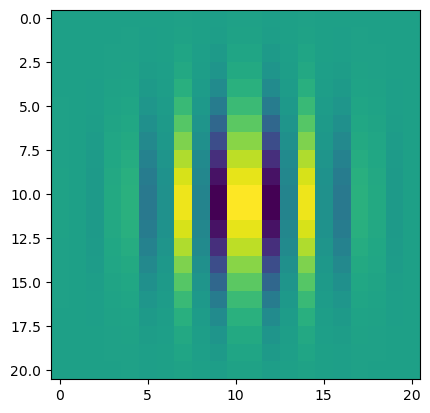

In [ ]:
#| eval: false
xmean, ymean = 0.5, 0.5
kernel_size = 21
fs = 21
sigmax, sigmay = 0.16, 0.16
freq = 6

x_, y_ = jnp.meshgrid(jnp.linspace(0,kernel_size/fs,num=kernel_size+1)[:-1], jnp.linspace(0,kernel_size/fs,num=kernel_size+1)[:-1])
g = model.gabor(x_, y_, xmean, ymean, sigmax, sigmay, freq=freq, theta=0, sigma_theta=0, rot_theta=0)
print(g.shape)
plt.imshow(g)
plt.show()

In [ ]:
kernel = model.return_kernel(params)
kernel.shape

(21, 21, 3, 1)

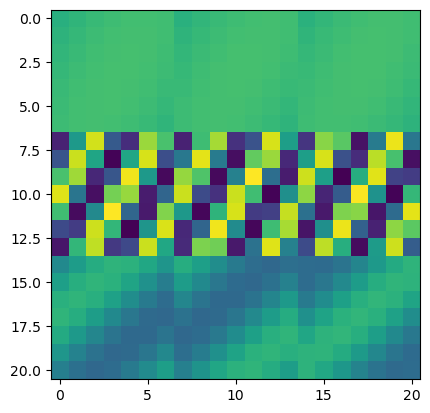

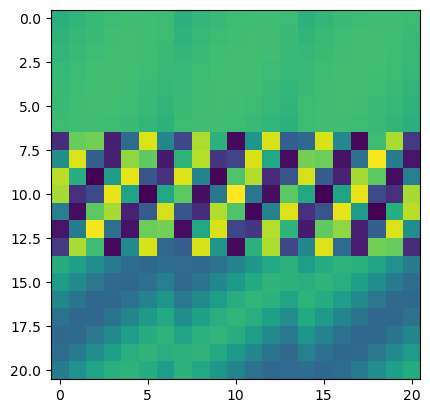

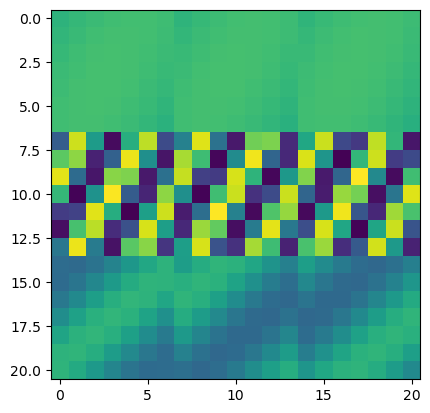

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
for k in jnp.transpose(kernel, (3,2,0,1))[0]:
    plt.imshow(k)
    plt.show()

We can test if the precalculated filters are updated when in training mode and stay the same when in evaluation mode:

In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=True)
assert not jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 34.1 ms, sys: 1.6 ms, total: 35.7 ms
Wall time: 26.9 ms


In [ ]:
outputs, updated_state = model.apply({"params": params, **state}, x, mutable=list(state.keys()), train=False)
assert jax.tree_util.tree_map(lambda x,y: (x==y).all(), state, updated_state)["precalc_filter"]["kernel"]

CPU times: user 11.4 ms, sys: 7.57 ms, total: 19 ms
Wall time: 14.8 ms


We see that there is a time difference in both executions, which makes sense because when `train=False`, the filters don't have to be calculated and thus the function should run faster.

And let's see if we're able to train the layer weights while maintaining the state:

In [ ]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(apply_fn, tx, inputs, opt_state, params, state):
    def loss(params):
        pred, updated_state = apply_fn({"params": params, **state}, 
                                       x, 
                                       mutable=list(state.keys()), 
                                       train=True)
        loss = ((pred-inputs)**2).sum()
        return loss, updated_state
    (l, updated_state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, updated_state, l

In [ ]:
model = GaussianLayer(features=3, kernel_size=21)
variables = model.init(random.PRNGKey(0), x)
# Split state and params (which are updated by optimizer).
state, params = variables.pop('params')
del variables  # Delete variables to avoid wasting resources
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)

for i in range(1001):
  opt_state, params, state, loss = update_step(
      model.apply, tx, x, opt_state, params, state)
  if i % 100 == 0: print(f"Loss {i}: {loss}")

Loss 0: 82426.7265625
Loss 100: 3053.466796875
Loss 200: 2899.94287109375
Loss 300: 2824.4873046875
Loss 400: 2777.02978515625
Loss 500: 2743.489501953125
Loss 600: 2718.09423828125
Loss 700: 2697.96728515625
Loss 800: 2681.487548828125
Loss 900: 2667.6611328125
Loss 1000: 2655.83837890625


The loss is going down, so everything looking good so far!